In [103]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go

from sklearn.neighbors import KNeighborsClassifier

In [104]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [105]:
qo = 1e-3   # W/mm^2
Cp = 658 #J/kg.K
rho = 7.6e-6 #kg/mm^3
kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 2 #mm/s
Q = 5 #W/mm2

In [106]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    return qo

In [107]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, mesh_factor,geo_file) -> None:
        self.img = self.createMesh(mesh_factor,geo_file)
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,mesh_factor,geo_file):
        '''Create Mesh File'''
        import gmsh
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            coordinates = coords[triNodesTags[ele]-1].T           #coordinates is dim * no. of points matrix
            # k_element = values[ind]
            k_element = kappa
            # rho_cp_element = values[ind]
            rho_cp_element = rho*Cp
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho*Cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]

                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [108]:
mesh = RectangularMesh(mesh_factor=2,geo_file='rectangle.geo')

(1542, 2)
(1542, 2)


In [109]:
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = S.shape[0]
nodes = np.arange(n)
dirichiletBoundaryTemperature = 20
Temperature = np.ones((n,1))*dirichiletBoundaryTemperature
interiorNodes = np.delete(nodes,dirichiletBoundary)

In [110]:
((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

array([[2.00000000e-003],
       [2.00000000e-003],
       [1.66836600e-001],
       ...,
       [3.91237714e-218],
       [1.54874712e-251],
       [2.37255991e-241]])

In [111]:
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
Temperature[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [112]:
np.sum(((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))

-10.0016

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


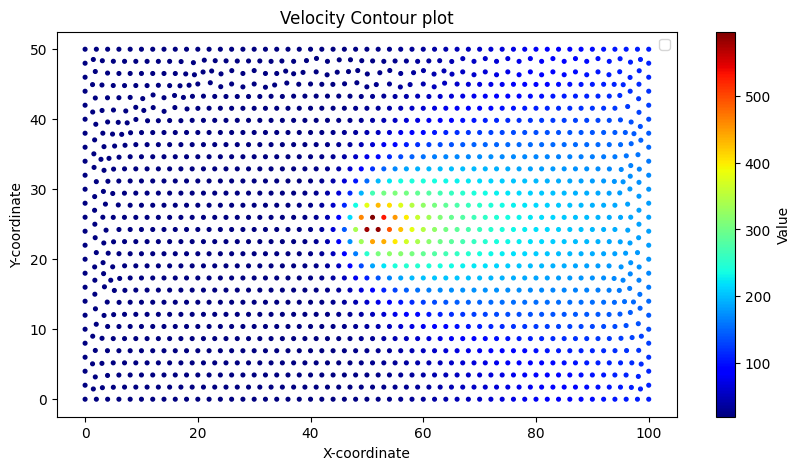

In [113]:
plt.figure(figsize=(10,5))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=Temperature, cmap='jet', s=7, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [116]:
np.max(Temperature)

595.7619154376987

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


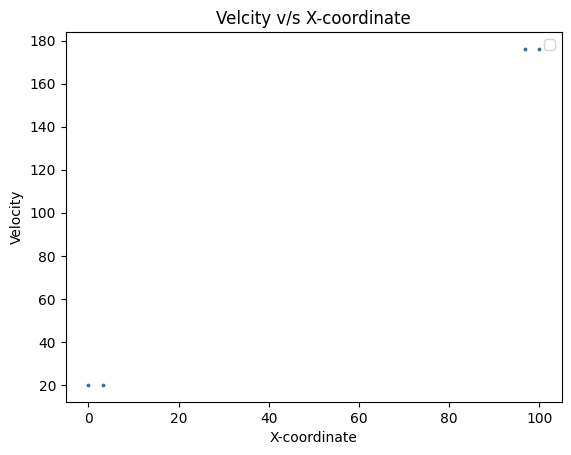

In [115]:
nodesForAnalysis = np.where(abs(coords[:,1]-20) <= .5)[0]
plt.title('Velcity v/s X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Velocity')
plt.scatter(coords[nodesForAnalysis, 0], Temperature[nodesForAnalysis],s=3)
plt.legend()
plt.show()